In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_excel('City-Specific Data/Seattle.xlsx')
df = df.dropna()

temperature = df['Temperature'].values.reshape(-1, 1)
energy_demand = df['EnergyDemand'].values.reshape(-1, 1)

scaler_temp = MinMaxScaler()
scaler_energy = MinMaxScaler()
temperature_normalized = scaler_temp.fit_transform(temperature)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 24
X, y = create_sequences(temperature_normalized, seq_length)
y = energy_demand_normalized[seq_length:]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
mape_scores = []

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

    loss = model.evaluate(X_test, y_test)
    print(f"Fold Test loss: {loss}")

    predictions_normalized = model.predict(X_test)

    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    print(f"Fold Mean Squared Error: {mse}")
    print(f"Fold Mean Absolute Error: {mae}")
    print(f"Fold Mean Absolute Percentage Error: {mape}")

average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average Mean Absolute Percentage Error: {average_mape}")

plt.figure(figsize=(12, 6))
plt.plot(scaler_energy.inverse_transform(y_test[:100]), label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand for Seattle (Last Fold)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0022 - val_loss: 1.5498e-04
Epoch 2/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1815e-04 - val_loss: 1.5425e-04
Epoch 3/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1497e-04 - val_loss: 1.5487e-04
Epoch 4/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.3467e-05 - val_loss: 1.3916e-04
Epoch 5/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.1676e-05 - val_loss: 1.3546e-04
Epoch 6/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.7497e-05 - val_loss: 1.3706e-04
Epoch 7/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.8207e-05 - val_loss: 1.3288e-04
Epoch 8/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0061e-04 - val_loss: 1.3584e-04
Epoch 9/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.0177e-05 - val_loss: 1.3613e-04
Epoch 10/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.6251e-05 - val_loss: 1.5004e-04
Epoch 11/50
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

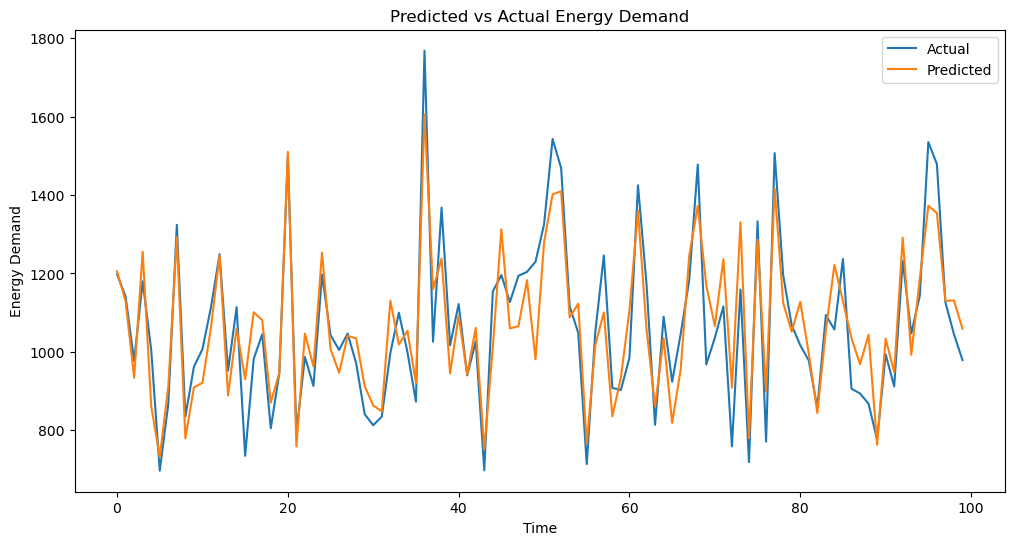

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(scaler_energy.inverse_transform(y_test[:100]), label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()